### 50.039 Image Segmentation Model

## Colab Specific Stuff

Some minor helper functions when running on google colab

In [2]:
# for google colab
import sys
on_colab = 'google.colab' in sys.modules
if on_colab:
  !pip install icecream

In [ ]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


## Data processing

In [3]:
# imports
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from PIL import Image
from pathlib import Path

import torch.nn as nn
from icecream import ic

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.transforms import v2

import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
if on_colab:
  dataset_path = '/content/drive/MyDrive/50.039_DL_Project/dataset'
  !ls $dataset_path
else:
  dataset_path = 'input'

Dataset_BUSI_with_GT


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.model_selection import train_test_split

class BusiDataset(VisionDataset):
    def __init__(self, root, transforms=None, transform=None, target_transform=None, split="train"):
        super().__init__(root, transforms, transform, target_transform)
        self.root = Path(root)
        mask_paths = list(root.rglob("*_mask.png"))
        ## The train/val/test split was done in the dataset to make it easier to reproduce
        train_paths, tmp_paths = train_test_split(mask_paths, test_size=0.2, random_state=0)
        if split != "train":
          val_paths, test_paths = train_test_split(tmp_paths, test_size=0.5, random_state=0)
          self.mask_paths = val_paths if split == "val" else test_paths
        else:
          self.mask_paths = train_paths

    def __getitem__(self, idx):
        mask_path = self.mask_paths[idx]
        img_path = Path(str(mask_path)[:-9] + ".png")
        mask = Image.open(mask_path)
        img = Image.open(img_path) ## TODO: make the image mono to reduct compute cost

        if self.transforms is not None:
            img, mask = self.transforms(img, mask)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.mask_paths)

## Defining model architecture

In [4]:
class SegmentModel(nn.Module):
    def __init__(self, input_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(input_dim),

            nn.Conv2d(input_dim, 64, 3, stride=2, padding=1),
            nn.ELU(),

            nn.BatchNorm2d(64),
            nn.Dropout2d(),
            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ELU(),


            nn.BatchNorm2d(64),
            nn.Dropout2d(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ELU(),

            nn.BatchNorm2d(128),
            nn.Dropout2d(),
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.ELU(),


            nn.BatchNorm2d(128),
            nn.Dropout2d(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ELU(),

            nn.BatchNorm2d(256),
            nn.Dropout2d(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.ELU(),
        )

        self.decoder = nn.Sequential(

            nn.BatchNorm2d(256),
            nn.Dropout2d(),
            nn.Conv2d(256, 128, 3, padding='same'),
            nn.ELU(),

            nn.BatchNorm2d(128),
            nn.Dropout2d(),
            nn.Conv2d(128, 64, 3, padding='same'),
            nn.ELU(),

            nn.BatchNorm2d(64),
            nn.Dropout2d(),
            nn.Conv2d(64, 32, 3, padding='same'),
            nn.ELU(),

            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding='same'),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True),
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [7]:
model = SegmentModel().to(device)
print(model)

SegmentModel(
  (encoder): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): ELU(alpha=1.0)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.5, inplace=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout2d(p=0.5, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ELU(alpha=1.0)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout2d(p=0.5, inplace=False)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (14): ELU(alpha=1.0)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
train_transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    # v2.RandomRotate((-90, 90)),
    v2.ColorJitter(brightness=0.2, # Random adjustments
                   contrast=0.2,
                   saturation=0.2,
                   hue=0.1),
    v2.RandomResizedCrop(size=(512, 512), antialias=True), ## By right suppose to be 500x500, but 512 just seems like a nicer number
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToDtype(torch.float32, scale=True)
])

# Splitting into train, test and validation sets
train_dataset = BusiDataset(Path(dataset_path) / "Dataset_BUSI_with_GT", transforms=train_transforms, split = "train")
val_dataset = BusiDataset(Path(dataset_path) / "Dataset_BUSI_with_GT", transforms=val_transforms, split = "val")
test_dataset = BusiDataset(Path(dataset_path) / "Dataset_BUSI_with_GT", transforms=val_transforms, split = "test")

ic(len(train_dataset), len(val_dataset), len(test_dataset))

# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

ic| len(train_dataset): 624
    len(val_dataset): 78
    len(test_dataset): 78


(624, 78, 78)

In [ ]:
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
import random
import math

class ThreadDataLoader():
  def __init__(self, dataset, batch_size = 1, shuffle = False, num_workers = 2, look_ahead = 2):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.num_workers = num_workers
    self.look_ahead = look_ahead

  def __getitem__(self, idx):
    return self.dataset[idx]

  def __len__(self):
    return math.ceil(len(self.dataset) / self.batch_size)

  def __iter__(self):
    executor = PoolExecutor(max_workers=self.num_workers)
    idxs = list(range(len(self.dataset)))
    if self.shuffle:
      random.shuffle(idxs)
    look_ahead = self.look_ahead * max(self.batch_size, self.num_workers)
    futures = {i: executor.submit(ThreadDataLoader.__getitem__, self, i) for i in idxs[:look_ahead]}
    collated_arr = []
    for i, idx in enumerate(idxs):
      data = futures[idx].result()
      del futures[idx]
      if i + look_ahead < len(idxs):
        futures[idxs[i + look_ahead]] = executor.submit(ThreadDataLoader.__getitem__, self, idxs[i + look_ahead])
      collated_arr.append(data)
      collated_batch = []
      if len(collated_arr) == self.batch_size:
          collated_batch = [torch.stack(data) for data in zip(*collated_arr)]
          yield collated_batch
          collated_arr = []
    if len(collated_arr) > 0:
      collated_batch = [torch.stack(data) for data in zip(*collated_arr)]
      yield collated_batch

# train_dataloader = ThreadDataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
# val_dataloader = ThreadDataLoader(val_dataset, batch_size=32, num_workers=4)
# test_dataloader = ThreadDataLoader(test_dataset, batch_size=32, num_workers=4)

In [ ]:
# change
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)

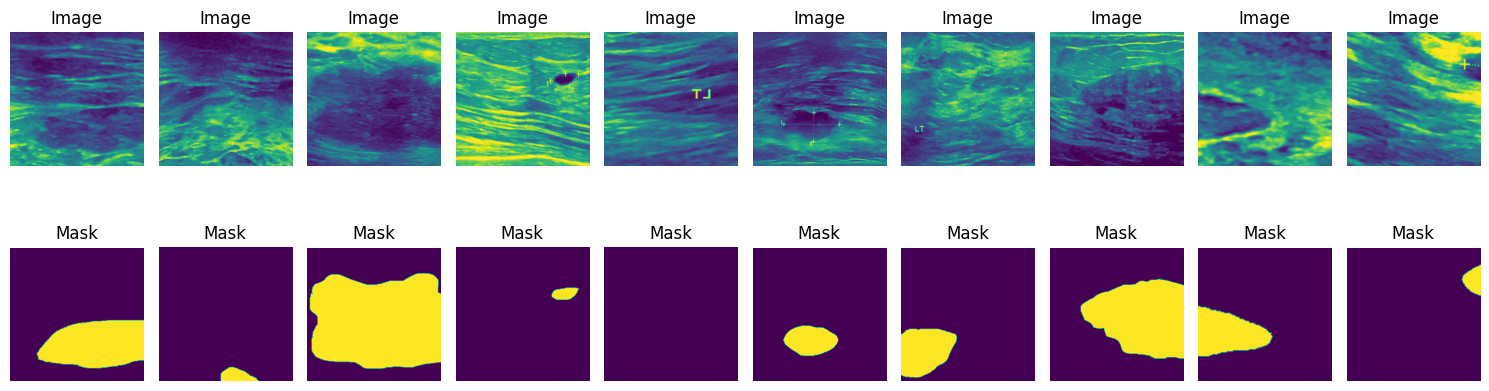

In [ ]:
# show how image looks like
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming your dataset provides a way to access individual samples by index
# Replace `get_sample(index)` with the actual method from your dataset
num_images_to_display = 10  # Change this according to your preference
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    sample = train_dataset[i]  # Get a sample from the dataset
    image, mask = sample  # Unpack the tuple

    image = image.squeeze().numpy()  # Remove batch dimension and convert to numpy array
    # image = (image * 0.5) + 0.5  # Unnormalize the image

    mask = mask.squeeze().numpy()  # Remove batch dimension and convert to numpy array
    # mask = (mask * 0.5) + 0.5  # Unnormalize the mask

    axes[0, i].imshow(image)  # Display the image
    axes[0, i].axis('off')
    axes[0, i].set_title('Image')

    axes[1, i].imshow(mask)  # Display the mask
    axes[1, i].axis('off')
    axes[1, i].set_title('Mask')

plt.tight_layout()
plt.show()

### Loss functions

In [ ]:
def dice_loss(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    # Flatten the predictions and ground truth
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute the intersection and union
    intersection = (y_true_flat * y_pred_flat).sum() + 1
    union = (y_true_flat).sum() + (y_pred_flat).sum() + 1

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

def composite_loss(*losses):
    def loss(y_pred, y_true):
        return sum(loss(y_pred, y_true) for loss in losses)
    return loss

## Training

In [ ]:
# Evaluation functions

# percent of pixels that are accurately classified
def pixel_acc(pred_mask, true_mask):
    correct_pixels = (pred_mask == true_mask).sum().item()
    total_pixels = true_mask.numel()
    accuracy = correct_pixels / total_pixels

    return accuracy

def pixel_f1(pred_mask, true_mask):
    tp = (pred_mask * true_mask).sum().item()
    fp = (pred_mask * (1 - true_mask)).sum().item()
    fn = ((1 - pred_mask) * true_mask).sum().item()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) == 0:
      return 0.0

    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# overlap between predicted bounding boxes and ground truth boxes
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(true_mask, pred_mask).sum().item()
    union = torch.logical_or(true_mask, pred_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# similarity between a predicted segmentation mask and the ground truth segmentation mask
# Calculate Dice coefficient
def dice_coefficient(pred_mask, true_mask):
    intersection = torch.logical_and(true_mask, pred_mask).sum().item()
    # Check if denominator is not zero before division
    true_mask_sum = true_mask.sum().item()
    pred_mask_sum = pred_mask.sum().item()
    if true_mask_sum == 0 and pred_mask_sum == 0:
        dice = 1.0  # Set Dice coefficient to 1 if both masks are empty
    else:
        dice = 2 * intersection / (true_mask_sum + pred_mask_sum)
    return dice

In [ ]:
model = SegmentModel().to(device)
# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = dice_loss
loss_fn = composite_loss(nn.BCEWithLogitsLoss(), dice_loss)
optimizer = torch.optim.Adam(model.parameters())
# og_model = model
# model = torch.compile(model)

# metrics = dict()
# metrics["train_losses"] = []

optimizer.zero_grad()

# initialize lists to store evaluation metrics
train_losses = []
val_losses = []

# validation metrics
f1s = []
ious = []
dice_coefficients = []

# training metrics
tf1 = []
tiou = []
tdice = []

for epoch in range(1000):
    train_loss = 0
    tf1_epoch = 0
    tiou_epoch = 0
    tdice_epoch = 0

    model.train()
    pbar = tqdm(train_dataloader)
    for batch in pbar:
        image, mask = batch
        image, mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        loss = loss_fn(pred_mask, mask)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
          loss = loss.cpu().item()
          train_loss += loss

          pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
          tf1_epoch += pixel_f1(pred_mask, mask)
          tiou_epoch += calculate_iou(pred_mask, mask)
          tdice_epoch += dice_coefficient(pred_mask, mask)
          pbar.set_postfix(loss = loss)

    # compute average metrics for the epoch
    train_loss /= len(train_dataloader)
    tf1_epoch /= len(train_dataloader)
    tiou_epoch /= len(train_dataloader)
    tdice_epoch /= len(train_dataloader)

    # update lists
    train_losses.append(train_loss)
    tf1.append(tf1_epoch)
    tiou.append(tiou_epoch)
    tdice.append(tdice_epoch)

    # Calculate evaluation metrics
    val_loss = 0
    f1_epoch = 0
    iou_epoch = 0
    dice_epoch = 0

    model.eval()
    for batch in val_dataloader:
        image, mask = batch
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            pred_mask = model(image)
            val_loss += loss_fn(pred_mask, mask).detach().cpu().item()

            # calculate evaluation metrics
            pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
            f1_epoch += pixel_f1(pred_mask, mask)
            iou_epoch += calculate_iou(pred_mask, mask)
            dice_epoch += dice_coefficient(pred_mask, mask)

    # compute average metrics for the epoch
    val_loss /= len(val_dataloader)
    f1_epoch /= len(val_dataloader)
    iou_epoch /= len(val_dataloader)
    dice_epoch /= len(val_dataloader)

    # update lists
    val_losses.append(val_loss)
    f1s.append(f1_epoch)
    ious.append(iou_epoch)
    dice_coefficients.append(dice_epoch)

    if epoch % 10 == 9:
      ic(epoch, train_loss, val_loss, f1_epoch, iou_epoch, dice_epoch, tf1_epoch, tiou_epoch, tdice_epoch)
# model = og_model

100%|██████████| 3/3 [00:01<00:00,  2.50it/s, loss=1.56]
ic| epoch: 9
    train_loss: 1.547165870666504
    val_loss: 1.5132871866226196
    f1_epoch: 0.14518820977468025
    iou_epoch: 0.07894247855378204
    dice_epoch: 0.14661454544388428
    tf1_epoch: 0.1619098018364795
    tiou_epoch: 0.0899716001916497
    tdice_epoch: 0.16375182315688405
100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=1.47]
ic| epoch: 19
    train_loss: 1.492301305135091
    val_loss: 1.439722220102946
    f1_epoch: 0.18638331648298187
    iou_epoch: 0.10485563008260528
    dice_epoch: 0.18920968299008653
    tf1_epoch: 0.19087824820821195
    tiou_epoch: 0.10721237153179493
    tdice_epoch: 0.19314730161659124
100%|██████████| 3/3 [00:01<00:00,  2.48it/s, loss=1.37]
ic| epoch: 29
    train_loss: 1.3745455741882324
    val_loss: 1.3441931009292603
    f1_epoch: 0.15976047128545287
    iou_epoch: 0.08721639451646236
    dice_epoch: 0.16189472385873085
    tf1_epoch: 0.16823910488321828
    tiou_epoch: 0.09307

In [ ]:
# continue training
for epoch in range(1000):
    train_loss = 0
    tf1_epoch = 0
    tiou_epoch = 0
    tdice_epoch = 0

    model.train()
    pbar = tqdm(train_dataloader)
    for batch in pbar:
        image, mask = batch
        image, mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        loss = loss_fn(pred_mask, mask)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
          loss = loss.cpu().item()
          train_loss += loss

          pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
          tf1_epoch += pixel_f1(pred_mask, mask)
          tiou_epoch += calculate_iou(pred_mask, mask)
          tdice_epoch += dice_coefficient(pred_mask, mask)
          pbar.set_postfix(loss = loss)

    # compute average metrics for the epoch
    train_loss /= len(train_dataloader)
    tf1_epoch /= len(train_dataloader)
    tiou_epoch /= len(train_dataloader)
    tdice_epoch /= len(train_dataloader)

    # update lists
    train_losses.append(train_loss)
    tf1.append(tf1_epoch)
    tiou.append(tiou_epoch)
    tdice.append(tdice_epoch)

    # Calculate evaluation metrics
    val_loss = 0
    f1_epoch = 0
    iou_epoch = 0
    dice_epoch = 0

    model.eval()
    for batch in val_dataloader:
        image, mask = batch
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            pred_mask = model(image)
            val_loss += loss_fn(pred_mask, mask).detach().cpu().item()

            # calculate evaluation metrics
            pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
            f1_epoch += pixel_f1(pred_mask, mask)
            iou_epoch += calculate_iou(pred_mask, mask)
            dice_epoch += dice_coefficient(pred_mask, mask)

    # compute average metrics for the epoch
    val_loss /= len(val_dataloader)
    f1_epoch /= len(val_dataloader)
    iou_epoch /= len(val_dataloader)
    dice_epoch /= len(val_dataloader)

    # update lists
    val_losses.append(val_loss)
    f1s.append(f1_epoch)
    ious.append(iou_epoch)
    dice_coefficients.append(dice_epoch)

    if epoch % 10 == 9:
      ic(epoch, train_loss, val_loss, f1_epoch, iou_epoch, dice_epoch, tf1_epoch, tiou_epoch, tdice_epoch)
# model = og_model

  0%|          | 0/3 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.329]
ic| epoch: 9
    train_loss: 0.5221709410349528
    val_loss: 0.8947897354761759
    f1_epoch: 0.4433284407664739
    iou_epoch: 0.289464775962257
    dice_epoch: 0.44971141949452864
    tf1_epoch: 0.6786612248660301
    tiou_epoch: 0.5199983625038347
    tdice_epoch: 0.6841428341116207
100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.37]
ic| epoch: 19
    train_loss: 0.537216047445933
    val_loss: 0.9088247815767924
    f1_epoch: 0.4388523791405306
    iou_epoch: 0.28595185858305117
    dice_epoch: 0.4454423147565201
    tf1_epoch: 0.6648916794907381
    tiou_epoch: 0.5037090028703489
    tdice_epoch: 0.6706898083526358
100%|██████████| 3/3 [00:01<00:00,  2.3

### Visualisation (2000 epochs)

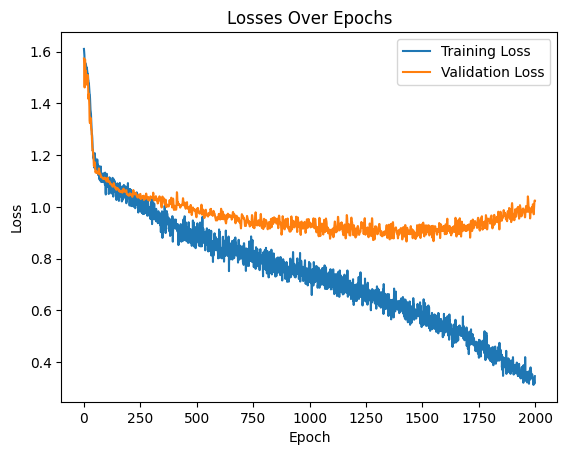

In [ ]:
# Plot losses
plt.plot([loss for loss in train_losses], label='Training Loss')
plt.plot([loss for loss in val_losses], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.show()

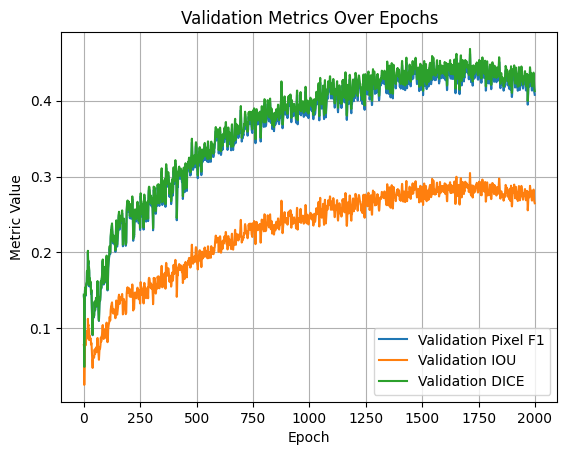

In [ ]:
# plot accuracy and evaluation metrics
plt.plot(f1s, label='Validation Pixel F1')
plt.plot(ious, label='Validation IOU')
plt.plot(dice_coefficients, label='Validation DICE')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

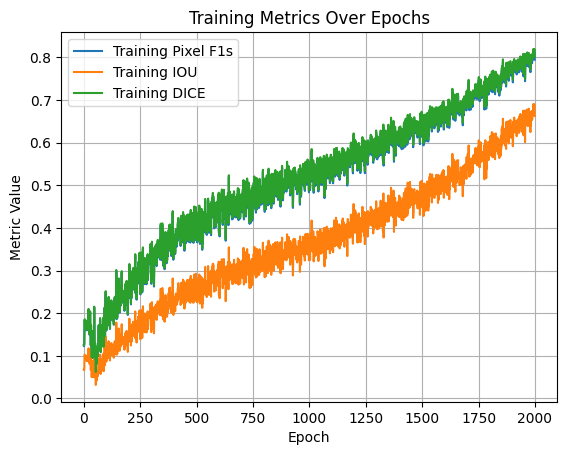

In [ ]:
# plot accuracy and evaluation metrics
plt.plot(tf1, label='Training Pixel F1s')
plt.plot(tiou, label='Training IOU')
plt.plot(tdice, label='Training DICE')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

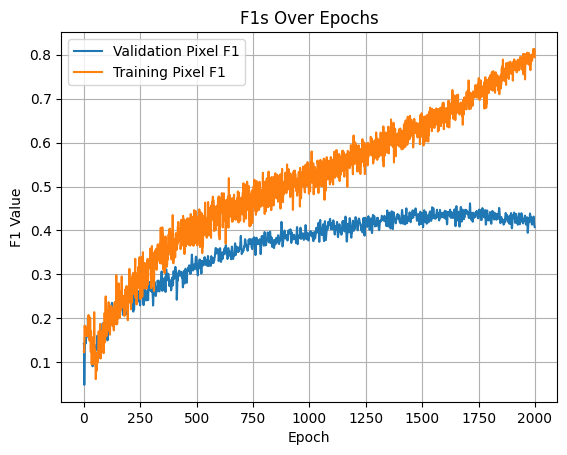

In [ ]:
# plot F1
plt.plot(f1s, label='Validation Pixel F1')
plt.plot(tf1, label='Training Pixel F1')

plt.xlabel('Epoch')
plt.ylabel('F1 Value')
plt.title('F1s Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

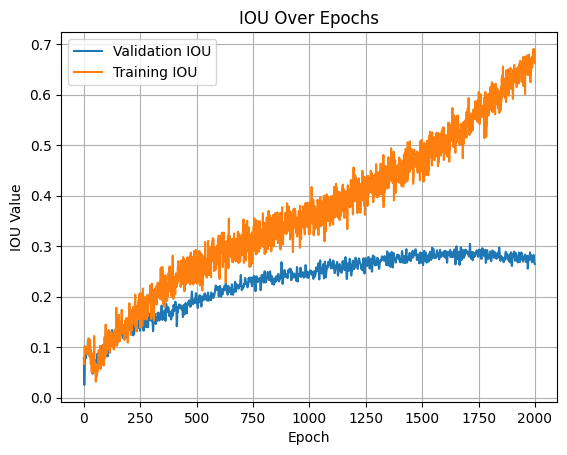

In [ ]:
# plot IOUs
plt.plot(ious, label='Validation IOU')
plt.plot(tiou, label='Training IOU')

plt.xlabel('Epoch')
plt.ylabel('IOU Value')
plt.title('IOU Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

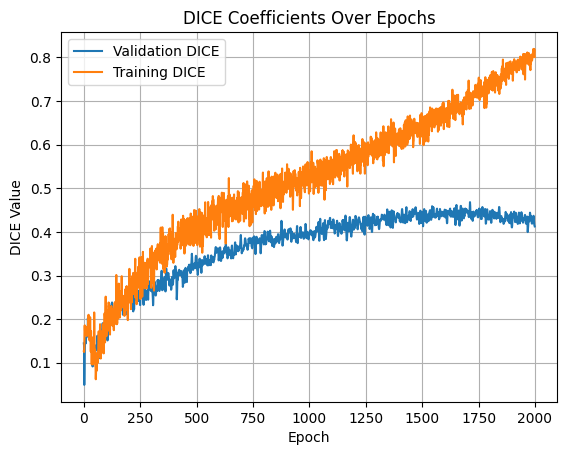

In [ ]:
# plot DICEs
plt.plot(dice_coefficients, label='Validation DICE')
plt.plot(tdice, label='Training DICE')

plt.xlabel('Epoch')
plt.ylabel('DICE Value')
plt.title('DICE Coefficients Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-103-c0b351e8fd48>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)


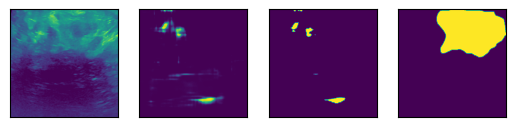

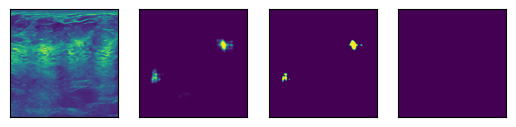

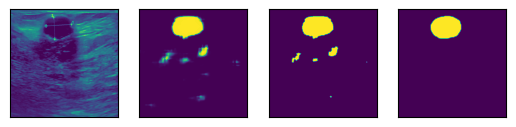

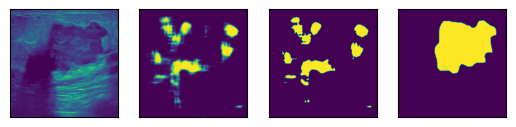

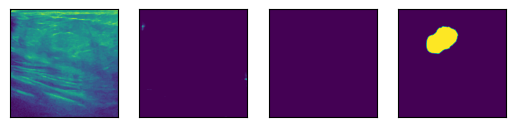

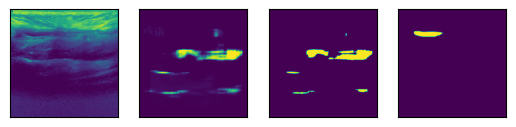

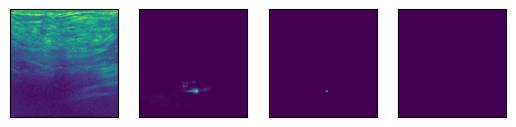

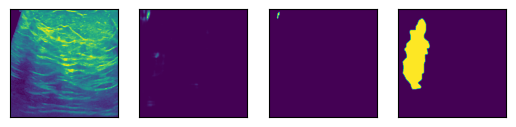

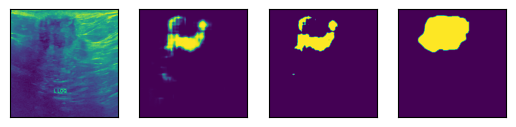

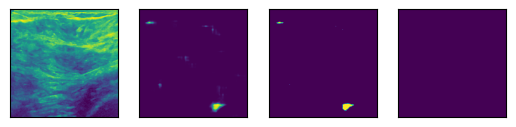

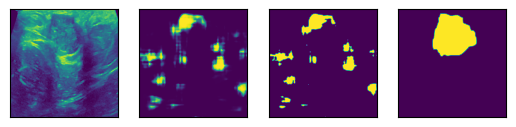

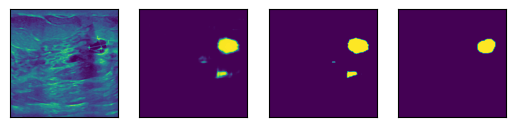

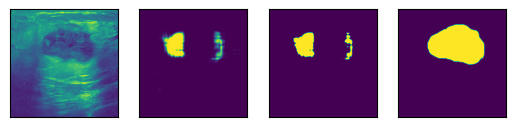

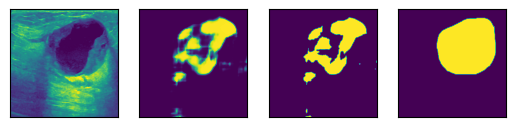

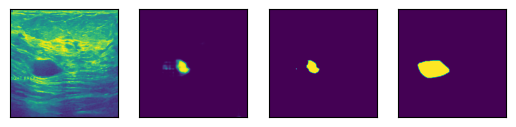

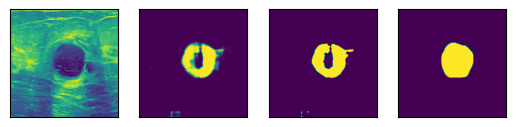

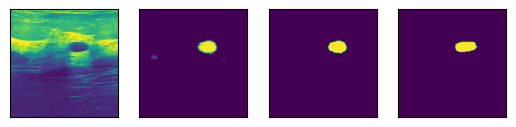

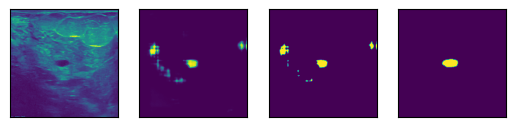

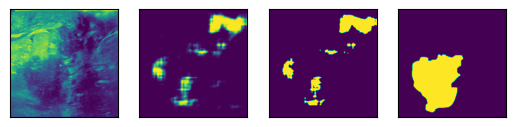

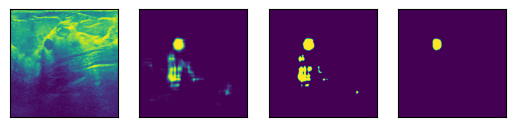

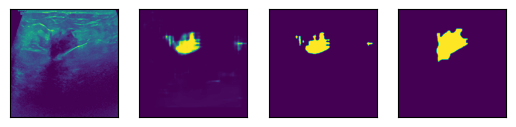

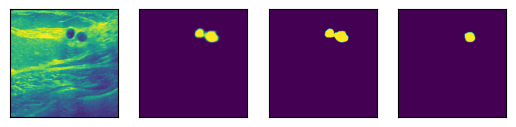

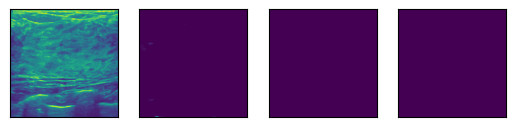

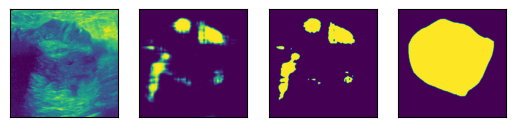

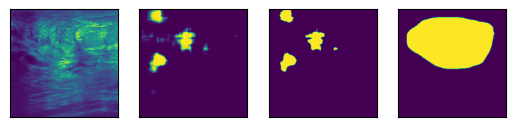

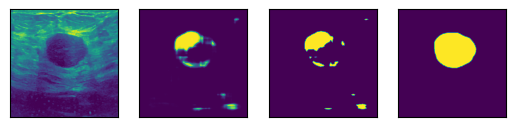

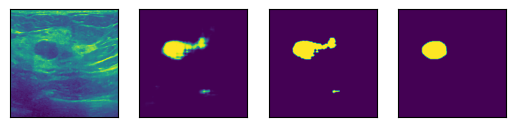

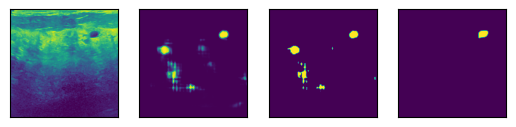

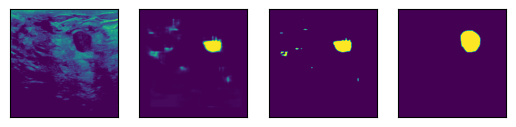

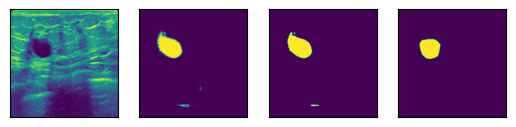

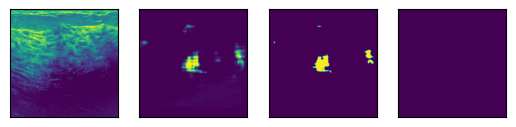

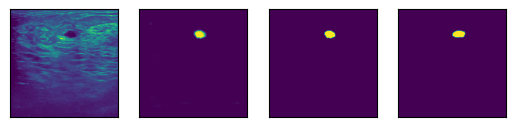

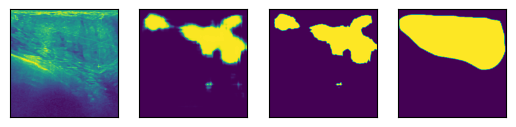

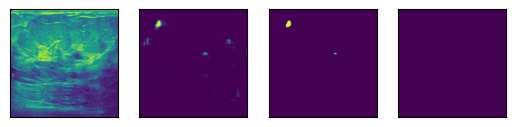

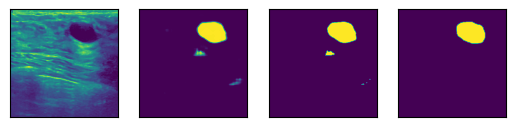

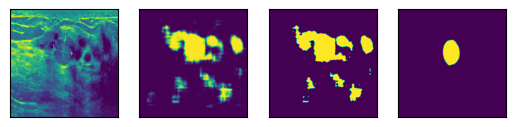

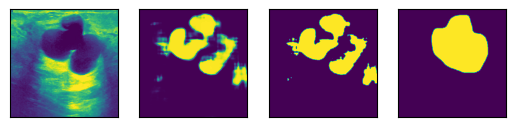

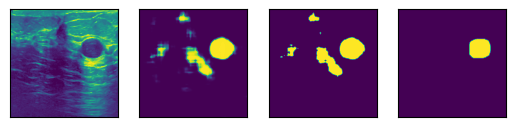

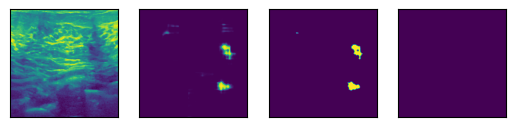

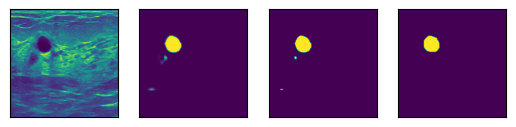

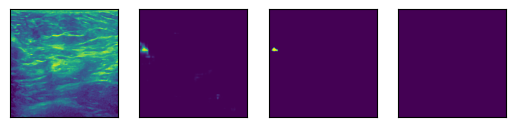

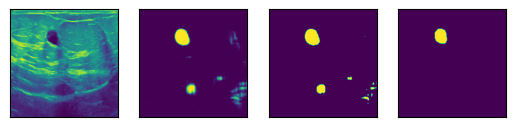

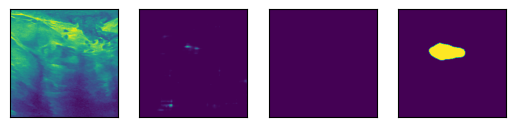

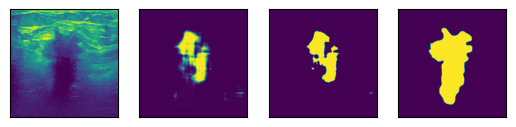

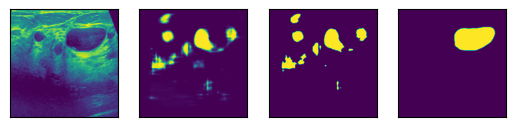

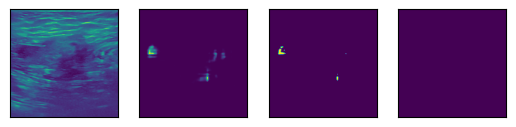

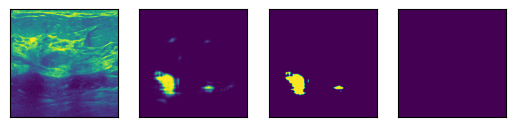

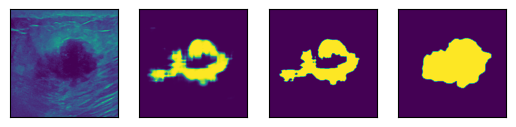

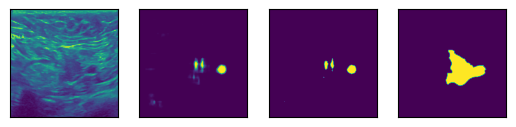

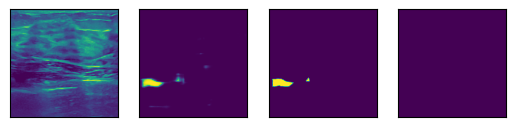

In [ ]:
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for i in range(50):
    img, mask = val_dataset[i]
    model.eval()
    out = torch.sigmoid(model(img.to(device).unsqueeze(0)).squeeze())
    binary_out = (out > 0.5).float()  # Convert to binary mask
    show([img, out, binary_out, mask])

### Evaluation on test set

In [ ]:
# change to test dataset
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for i in range(len(test_dataset)):
    img, mask = test_dataset[i]
    model.eval()
    out = torch.sigmoid(model(img.to(device).unsqueeze(0)).squeeze())
    binary_out = (out > 0.5).float()  # Convert to binary mask
    show([img, out, binary_out, mask])

Output hidden; open in https://colab.research.google.com to view.

### Evaluation
- Calculating evaluation metrics on the test dataset

In [ ]:
# Evaluation loop
test_pixel_f1s = []
test_ious = []
test_dice_scores = []

model.eval()
for batch in test_dataloader:
    image, mask = batch
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        pred_mask = model(image)
        pred_mask_binary = (torch.sigmoid(pred_mask) > 0.5).float()

        # Calculate pixel f1
        pixel_f1_score = pixel_f1(pred_mask_binary, mask)
        test_pixel_f1s.append(pixel_f1_score)

        # Calculate IoU
        iou = calculate_iou(pred_mask_binary, mask)
        test_ious.append(iou)

        # Calculate Dice coefficient
        dice_score = dice_coefficient(pred_mask_binary, mask)
        test_dice_scores.append(dice_score)

avg_test_pixel_f1 = sum(test_pixel_f1s) / len(test_pixel_f1s)
avg_test_iou = sum(test_ious) / len(test_ious)
avg_test_dice_score = sum(test_dice_scores) / len(test_dice_scores)

print("Test Pixel F1:", avg_test_pixel_f1)
print("Average IoU on Test Dataset:", avg_test_iou)
print("Average Dice Coefficient on Test Dataset:", avg_test_dice_score)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Pixel F1: 0.8949948648496733
Average IoU on Test Dataset: 0.8150839455947413
Average Dice Coefficient on Test Dataset: 0.9039819517449006


save model

In [ ]:
# save model using torch
torch.save(model, 'saved_models/naive-2000epochs.pth')
# torch.save(model.state_dict(), '/content/drive/MyDrive/50.039_DL_Project/saved_models/model_parameters.pth')

In [ ]:
torch.save(model.state_dict(), 'saved_models/naive-2000epochs-params.pth')

In [ ]:
torch.save(dict(train_losses = train_losses, val_losses = val_losses, f1s = f1s, ious = ious, dice_coefficients = dice_coefficients, tf1 = tf1, tiou = tiou, tdice = tdice), 'saved_models/naive-2000epoch-dict.pth')